<a href="https://colab.research.google.com/github/MohammadParsaTheFirst/Deep-learning-course/blob/main/HW5/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Full Name: **[`MohammadParsa Dini`]**
- Student ID: **[`400101204`]**

# 🧠 Homework 4: Transformer for Sentiment Analysis

## 📌 Objective

In this assignment, you will **implement a Transformer-based model for sentiment analysis** on the IMDb movie review dataset. You will:

- 🧹 Preprocess and clean real-world text data.
- 🏗️ Build a Transformer classifier from scratch (including positional encoding).
- 🧠 Train the model to classify IMDb reviews as **positive** or **negative**.
- 📈 Evaluate model performance on the test set.

---

## 📚 Learning Goals

By the end of this assignment, you should be able to:

- Understand how the Transformer encoder works in NLP.
- Implement tokenization, padding, and vocabulary creation.
- Train a Transformer-based model for text classification.
- Measure and interpret model performance on a real-world dataset.

---

## 📦 Dataset

We use the **IMDb movie reviews dataset**:

- Contains 50,000 highly polar movie reviews (25,000 for training and 25,000 for testing).
- Each review is labeled as either **positive (1)** or **negative (0)**.
- You will clean the raw text, tokenize it, and build a vocabulary before training.

---

## 🏗️ Model Architecture

You will build a **Transformer Encoder** model that includes:

- Word Embedding Layer
- Positional Encoding Layer
- Multi-head Self-Attention Blocks
- Feedforward Layers
- Final Classification Head

---

## ⚙️ Training Details

- Optimizer: `Adam`
- Loss Function: `CrossEntropyLoss`
- Batch Size: `32`
- Learning Rate: `1e-3`
- Epochs: `5`

---

## 🎯 Evaluation Criteria

Your final implementation will be evaluated on:

- ✅ Correct implementation of the Transformer classifier.
- ✅ Clean and modular code (e.g., `Dataset`, `Dataloader`, `Model`, `Train` functions).
- ✅ Accuracy on the IMDb test set.
- ✅ Proper text preprocessing and vocabulary handling.
- ✅ Well-commented and readable code.

---



In [1]:
import os
import re
import tarfile
import requests
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import copy

In [2]:
## Do not edit part

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def download_imdb(data_path="./imdb"):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    os.makedirs(data_path, exist_ok=True)
    filepath = os.path.join(data_path, "aclImdb_v1.tar.gz")

    if not os.path.exists(filepath):
        print("Downloading IMDb dataset...")
        r = requests.get(url, stream=True)
        with open(filepath, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024): f.write(chunk)

        print("Extracting...")
        with tarfile.open(filepath, "r:gz") as tar:
            tar.extractall(path=data_path)
    print("Done.")

download_imdb()

def clean_text(text):
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.lower()

def load_imdb_data(base_path, split='train'):
    data = []
    for label in ['pos', 'neg']:
        folder = os.path.join(base_path, f'aclImdb/{split}/{label}')
        for fname in os.listdir(folder):
            with open(os.path.join(folder, fname), 'r', encoding='utf8') as f:
                text = clean_text(f.read())
                data.append((text, 1 if label == 'pos' else 0))
    return data

train_raw = load_imdb_data("./imdb", split='train')
test_raw = load_imdb_data("./imdb", split='test')

Extracting...
Done.


In [3]:
print(device)

cuda


In [4]:
## Do not edit part
def tokenize(text):
    return text.split()

# Build vocab
counter = Counter()
for text, _ in train_raw:
    counter.update(tokenize(text))

vocab = {"<pad>": 0, "<unk>": 1}
for word, freq in counter.items():
    if freq >= 5:
        vocab[word] = len(vocab)

def encode(text):
    return [vocab.get(w, vocab["<unk>"]) for w in tokenize(text)]

class IMDBDataset(Dataset):
    def __init__(self, data):
        self.data = [(encode(text), label) for text, label in data]
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts = [torch.tensor(x) for x in texts]
    texts = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    return texts.to(device), torch.tensor(labels).to(device)

train_dataset = IMDBDataset(train_raw)
test_dataset = IMDBDataset(test_raw)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


In [5]:
## TODO: complete the PositionalEncoding module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        ## Sin , Cos positional encoding
        pe[:, 0::2] = torch.sin(div_term * position)
        pe[:, 1::2] = torch.cos(div_term * position)
        self.pe = pe.unsqueeze(0)
        # self.register_buffer('pe_buffer', self.pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


In [6]:
## To do: complete MultiheadAttention module
class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    # def forward(self, query, key, value, key_padding_mask=None):
    #     batch_size = query.size(1)

    #     # Project inputs to query, key, value
    #     q = self.q_proj(query).view(-1, batch_size * self.num_heads, self.head_dim).transpose(0, 1)
    #     k = self.k_proj(key).view(-1, batch_size * self.num_heads, self.head_dim).transpose(0, 1)
    #     v = self.v_proj(value).view(-1, batch_size * self.num_heads, self.head_dim).transpose(0, 1)

    #     # Scaled dot-product attention
    #     attn_output, attn_weights = self.scaled_dot_product_attention(q, k, v)

    #     # Concatenate heads and project back to original dimension
    #     attn_output = attn_output.transpose(0, 1).contiguous().view(-1, batch_size, self.embed_dim)
    #     attn_output = self.out_proj(attn_output).transpose(0,1)

    #     return attn_output, attn_weights
    def forward(self, query, key, value, key_padding_mask=None):
        seq_len, batch_size, _ = query.size()

        # Linear projections
        q = self.q_proj(query).view(seq_len, batch_size, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(key).view(seq_len, batch_size, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(value).view(seq_len, batch_size, self.num_heads, self.head_dim).transpose(1, 2)

        # Now shape is (seq_len, num_heads, batch_size, head_dim)
        # --> make shape (batch_size * num_heads, seq_len, head_dim) for efficient bmm
        q = q.permute(1, 2, 0, 3).reshape(batch_size * self.num_heads, seq_len, self.head_dim)
        k = k.permute(1, 2, 0, 3).reshape(batch_size * self.num_heads, seq_len, self.head_dim)
        v = v.permute(1, 2, 0, 3).reshape(batch_size * self.num_heads, seq_len, self.head_dim)

        attn_output, attn_weights = self.scaled_dot_product_attention(q, k, v)  # output: (B*H, seq_len, head_dim)

        # Reshape back
        attn_output = attn_output.view(batch_size, self.num_heads, seq_len, self.head_dim)
        attn_output = attn_output.permute(2, 0, 1, 3).contiguous().view(seq_len, batch_size, self.embed_dim)

        # Final projection
        attn_output = self.out_proj(attn_output)
        return attn_output, attn_weights


    ## To do
    def scaled_dot_product_attention(self, q, k, v):
        dk = q.size(-1)
        attn_scores = torch.bmm(q, k.transpose(1,2)) / torch.sqrt( torch.tensor(dk, dtype=torch.float32, device=q.device))
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        output = torch.matmul(attn_weights, v)
        return output, attn_weights





In [7]:
## To do: complete the forward function
import torch.nn.functional as F

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # Self attention
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        # Feedforward
        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src2 = src + self.dropout2(src2)
        src = self.norm2(src)
        src = self.norm2(src)
        return src


In [8]:
class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])

    ## To do
    def forward(self, src):
        output = src
        for layer in self.layers:
            output = layer(output)
        return output

In [9]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = TransformerEncoderLayer(d_model, nhead, d_model*2, dropout=0.1)
        self.transformer = TransformerEncoder(encoder_layer, num_layers)

        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, src):
        ## get the embedding
        x = self.embedding(src)
        ## pos encode
        x = self.pos_encoder(x)
        x = x.transpose(0,1) # (seq_len, batch, dim)
        x = self.transformer(x)
        return self.fc(x[0])  # Use first token as representation

model = TransformerClassifier(len(vocab)).to(device)

In [10]:
## To do: complete the training loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# def train(model, loader):.
#     model.train()
#     total_loss, correct = 0, 0
#     for x, y in loader:
#         x, y = x.to(device), y.to(device)
#         optimizer.zero_grad()
#         output = model(x)
#         loss += criterion(output, y)

#         loss.backward()
#         optimizer.step()
#         total_loss = loss.item()
#         correct += (output.argmax(1) == y).sum().item()

#     return total_loss / len(loader), correct / len(loader.dataset)

def train(model, loader):
    model.train()
    total_loss, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (output.argmax(1) == y).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)


def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()
    return correct / len(loader.dataset)



In [ ]:
torch.save(model.state_dict(),"transformer_epoch20.pt")
torch.save(model, "transformer_model_epoch20.pth")

## 📝 Bonus (Optional)

- 🔍 Experiment with different model hyperparameters (e.g., `nhead`, `d_model`, `num_layers`).
- 📊 Plot training and validation accuracy over epochs.
- 📌 Use attention weights to interpret model focus.




Epoch 1: Train Loss 0.6991, Train Acc 0.5117, Test Acc 0.5096
Epoch 2: Train Loss 0.6952, Train Acc 0.5088, Test Acc 0.5028
Epoch 3: Train Loss 0.6949, Train Acc 0.5105, Test Acc 0.5026
Epoch 4: Train Loss 0.6952, Train Acc 0.5008, Test Acc 0.5000
Epoch 5: Train Loss 0.6949, Train Acc 0.5017, Test Acc 0.5029
Epoch 6: Train Loss 0.6944, Train Acc 0.4987, Test Acc 0.5094
Epoch 7: Train Loss 0.6933, Train Acc 0.5117, Test Acc 0.5126
Epoch 8: Train Loss 0.6923, Train Acc 0.5180, Test Acc 0.5148
Epoch 9: Train Loss 0.6918, Train Acc 0.5161, Test Acc 0.5321
Epoch 10: Train Loss 0.6932, Train Acc 0.5078, Test Acc 0.5060
Epoch 11: Train Loss 0.6928, Train Acc 0.5088, Test Acc 0.5116
Epoch 12: Train Loss 0.6919, Train Acc 0.5167, Test Acc 0.5048
Epoch 13: Train Loss 0.6928, Train Acc 0.5133, Test Acc 0.5167
Epoch 14: Train Loss 0.6929, Train Acc 0.5089, Test Acc 0.5036
Epoch 15: Train Loss 0.6928, Train Acc 0.5015, Test Acc 0.5086
Epoch 16: Train Loss 0.6926, Train Acc 0.5085, Test Acc 0.5195
E

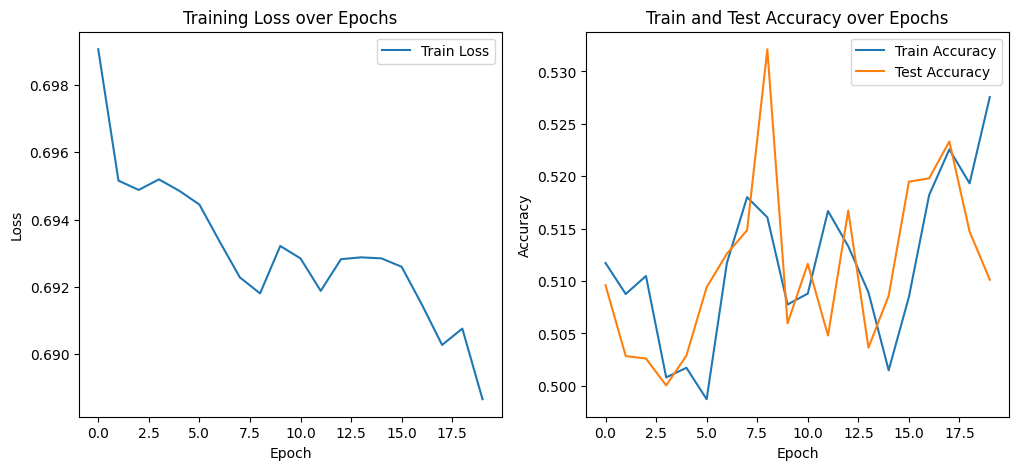

In [13]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(20):
    train_loss, train_acc = train(model, train_loader)
    test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, Test Acc {test_acc:.4f}")

# Plotting
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()

plt.show()


Epoch 1: Train Loss 0.7470, Train Acc 0.5021, Test Acc 0.4941
Epoch 2: Train Loss 0.7486, Train Acc 0.4997, Test Acc 0.4941
Epoch 3: Train Loss 0.7478, Train Acc 0.5016, Test Acc 0.4941
Epoch 4: Train Loss 0.7491, Train Acc 0.4984, Test Acc 0.4941
Epoch 5: Train Loss 0.7481, Train Acc 0.5015, Test Acc 0.4941
Epoch 6: Train Loss 0.7490, Train Acc 0.4974, Test Acc 0.4941
Epoch 7: Train Loss 0.7476, Train Acc 0.5026, Test Acc 0.4941
Epoch 8: Train Loss 0.7495, Train Acc 0.5000, Test Acc 0.4941
Epoch 9: Train Loss 0.7486, Train Acc 0.5002, Test Acc 0.4941
Epoch 10: Train Loss 0.7474, Train Acc 0.5000, Test Acc 0.4941
Epoch 11: Train Loss 0.7491, Train Acc 0.4976, Test Acc 0.4941
Epoch 12: Train Loss 0.7486, Train Acc 0.5008, Test Acc 0.4941
Epoch 13: Train Loss 0.7472, Train Acc 0.4987, Test Acc 0.4941
Epoch 14: Train Loss 0.7486, Train Acc 0.5020, Test Acc 0.4941
Epoch 15: Train Loss 0.7490, Train Acc 0.4992, Test Acc 0.4941
Epoch 16: Train Loss 0.7482, Train Acc 0.5009, Test Acc 0.4941
E

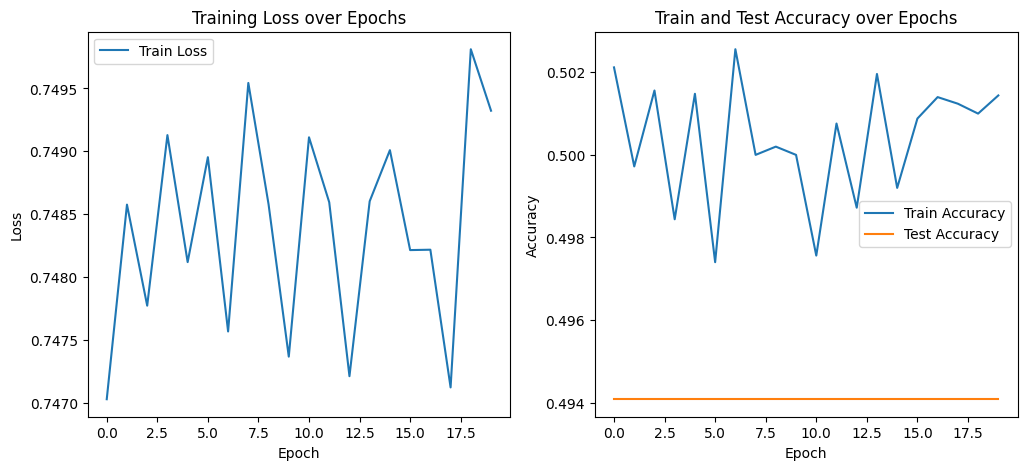

In [17]:
import seaborn as sns

d_model = 128
nhead = 4
num_layers = 3

model = TransformerClassifier(d_model=d_model, nhead=nhead, num_layers=num_layers, vocab_size=len(vocab)).to(device)

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(20):
    train_loss, train_acc = train(model, train_loader)
    test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, Test Acc {test_acc:.4f}")

# Plotting
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()

plt.show()



